In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
import time
%matplotlib inline

In [5]:
(train_data , test_data),(_ , _) = tf.keras.datasets.mnist.load_data()

2


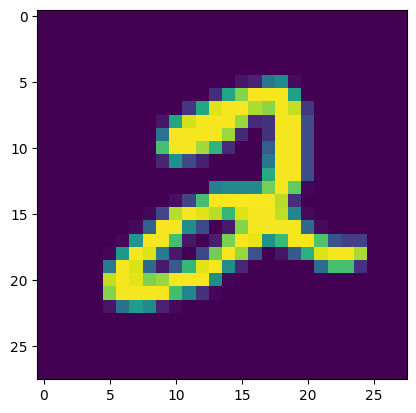

In [6]:
 plt.imshow(train_data[5])
print(test_data[5])

In [7]:
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1).astype('float32')
train_data = (train_data - 127.5) / 127.5

In [8]:
BUFFER_SIZE=6000
BATCH_SIZE=256
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


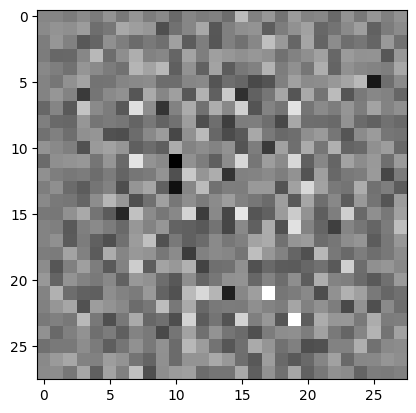

In [10]:
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[-0.00065107]], shape=(1, 1), dtype=float32)


In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output) ####################
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [15]:
def generator_loss(fake_output):
    fake_loss = cross_entropy(tf.ones_like(fake_output),fake_output)
    return fake_loss

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [27]:
epochs = 30
noise_dim = 100
num_examples_to_generate = 16


In [18]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  ############################
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)


    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


  generate_and_save_images(generator,epochs, seed)

In [21]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Time for epoch 1 is 11.93617582321167 sec
Time for epoch 2 is 12.095820665359497 sec
Time for epoch 3 is 11.864732265472412 sec
Time for epoch 4 is 11.798134565353394 sec
Time for epoch 5 is 11.69646430015564 sec
Time for epoch 6 is 11.674076080322266 sec
Time for epoch 7 is 11.710827827453613 sec
Time for epoch 8 is 11.792046070098877 sec
Time for epoch 9 is 11.839516878128052 sec
Time for epoch 10 is 11.842492818832397 sec
Time for epoch 11 is 11.838900327682495 sec
Time for epoch 12 is 11.814155101776123 sec
Time for epoch 13 is 11.750632524490356 sec
Time for epoch 14 is 11.757575035095215 sec
Time for epoch 15 is 11.769100904464722 sec
Time for epoch 16 is 11.765215158462524 sec
Time for epoch 17 is 11.768006801605225 sec
Time for epoch 18 is 11.751978397369385 sec
Time for epoch 19 is 11.768086671829224 sec
Time for epoch 20 is 11.760354280471802 sec
Time for epoch 21 is 20.462137699127197 sec
Time for epoch 22 is 11.716104507446289 sec
Time for epoch 23 is 11.849337577819824 sec

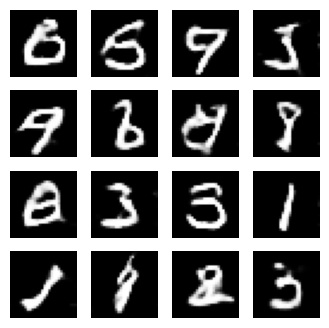

In [28]:
train(train_dataset, epochs)